In [15]:
import pandas as pd
from constants import file_movie, file_ratings, traducao_generos

In [16]:
def read_csv():
    df_movies = pd.read_csv(file_movie, delimiter=",")
    df_ratings = pd.read_csv(file_ratings, delimiter=",")
    return df_movies, df_ratings

def explode_df(df_movies):
    df_movies_exploded = df_movies.copy()
    df_movies_exploded["genres"] = df_movies_exploded["genres"].str.split("|")
    df_movies_exploded = df_movies_exploded.explode("genres")
    df_movies_exploded = df_movies.copy()
    df_movies_exploded["genres"] = df_movies_exploded["genres"].str.split("|")
    df_movies_exploded = df_movies_exploded.explode("genres")
    df_movies_exploded.head()
    return df_movies_exploded

def merge_dfs(df_movies_exploded, df_ratings):
    df_user_genres = df_ratings.merge(df_movies_exploded[["movieId", "genres"]], on="movieId")
    df_genero_por_usuario = df_user_genres.groupby(["userId", "genres"]).size().reset_index(name="count")
    df_top_generos = df_genero_por_usuario.sort_values(["userId", "count"], ascending=[True, False]) \
                                        .groupby("userId").head(3)
    return df_top_generos

In [17]:
df_movies, df_ratings = read_csv()
display(df_movies.head(1))
display(df_ratings.head(1))

df_movies_exploded = explode_df(df_movies=df_movies)
display(df_movies_exploded.head())

df_merged_top_generos = merge_dfs(df_movies_exploded=df_movies_exploded, df_ratings=df_ratings)
df_merged_top_generos["genres"] = df_merged_top_generos["genres"].map(traducao_generos)
df_merged_top_generos.head(4)






,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044


,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


,userId,genres,count
7,1,Drama,53
4,1,Comédia,23
13,1,Romance,18
24,2,Drama,91


In [18]:
# Estatísticas descritivas das notas
stats = df_ratings['rating'].describe()
print(stats)


count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


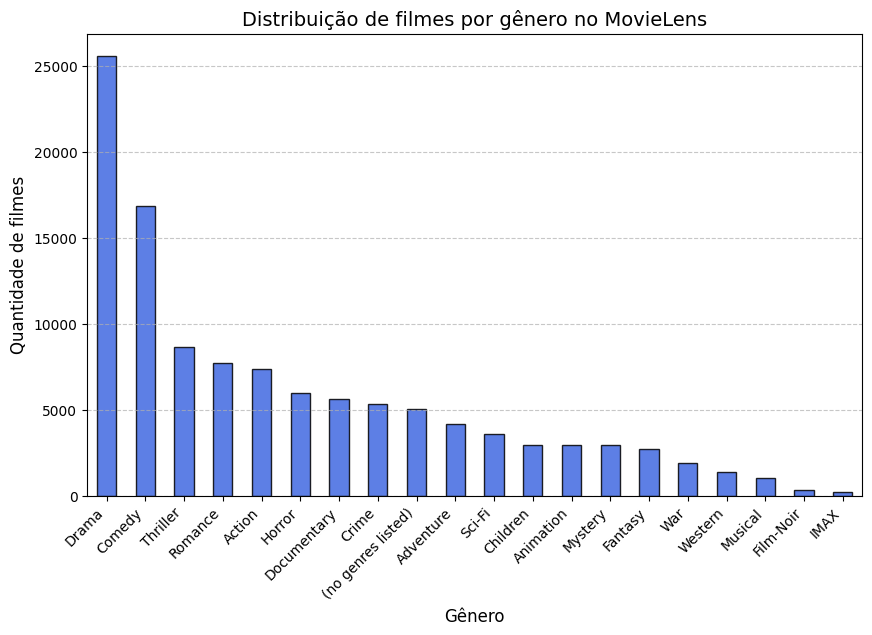

In [11]:
import matplotlib.pyplot as plt

# Separa os gêneros em listas
df_movies_exploded = df_movies.copy()
df_movies_exploded["genres"] = df_movies_exploded["genres"].str.split("|")
df_movies_exploded = df_movies_exploded.explode("genres")

# Conta a frequência de filmes por gênero
generos_count = df_movies_exploded["genres"].value_counts()

plt.figure(figsize=(10,6))
generos_count.plot(kind="bar", color="royalblue", edgecolor="black", alpha=0.85)

plt.title("Distribuição de filmes por gênero no MovieLens", fontsize=14)
plt.xlabel("Gênero", fontsize=12)
plt.ylabel("Quantidade de filmes", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


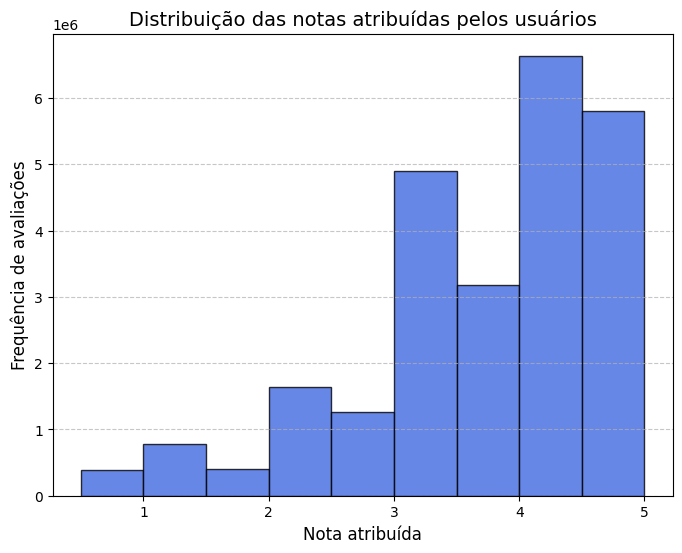

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_ratings['rating'], bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5], color="royalblue", edgecolor="black", alpha=0.8)

plt.title("Distribuição das notas atribuídas pelos usuários", fontsize=14)
plt.xlabel("Nota atribuída", fontsize=12)
plt.ylabel("Frequência de avaliações", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

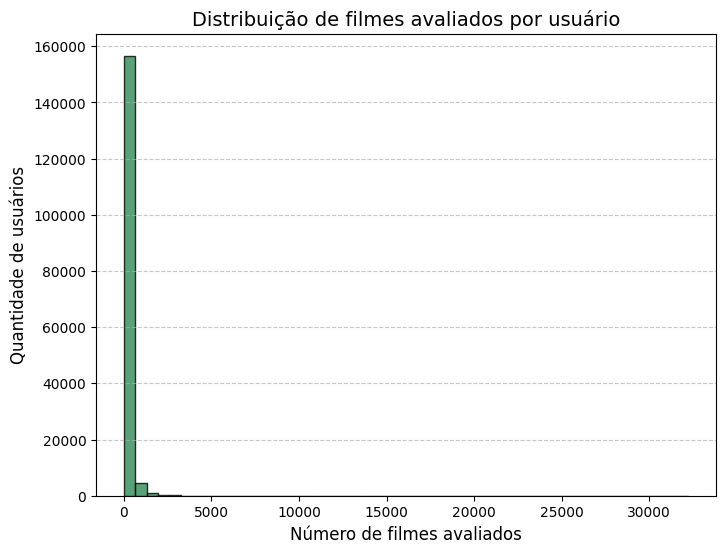

In [6]:
import matplotlib.pyplot as plt

# Conta quantas avaliações cada usuário fez
avaliacoes_por_usuario = df_ratings.groupby("userId")["movieId"].count()

plt.figure(figsize=(8,6))
plt.hist(avaliacoes_por_usuario, bins=50, color="seagreen", edgecolor="black", alpha=0.8)

plt.title("Distribuição de filmes avaliados por usuário", fontsize=14)
plt.xlabel("Número de filmes avaliados", fontsize=12)
plt.ylabel("Quantidade de usuários", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [19]:
df_merged_top_generos.head(20)


,userId,genres,count
7,1,Drama,53
4,1,Comédia,23
13,1,Romance,18
24,2,Drama,91
19,2,Aventura,75
18,2,Ação,66
36,3,Ação,334
52,3,Thriller,239
43,3,Drama,232
55,4,Ação,145


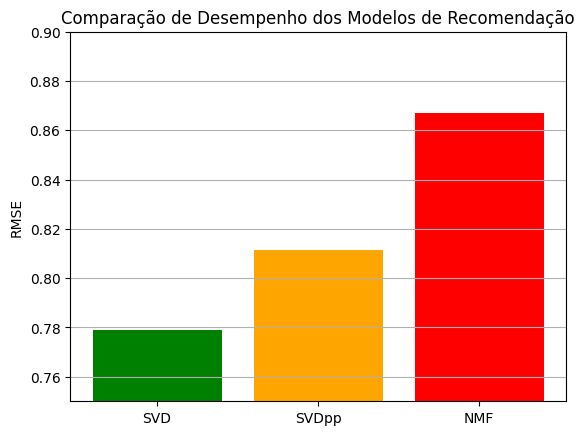

In [10]:
import matplotlib.pyplot as plt

modelos = ['SVD', 'SVDpp', 'NMF']
rmse = [0.7788, 0.8112, 0.8668]

plt.bar(modelos, rmse, color=['green', 'orange', 'red'])
plt.ylabel("RMSE")
plt.title("Comparação de Desempenho dos Modelos de Recomendação")
plt.ylim(0.75, 0.9)
plt.grid(axis='y')
plt.show()


In [20]:
import pandas as pd
import joblib
from surprise import Dataset, Reader

# Carregar os dados
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")
modelo_svd = joblib.load("modelo_svd_otimizado.pkl")

# Amostra de 10%
df_ratings_sample = df_ratings.sample(frac=0.1, random_state=42)

# Dataset da Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data_sample = Dataset.load_from_df(df_ratings_sample[["userId", "movieId", "rating"]], reader)

# Treino e Teste com a amostra
trainset_sample = data_sample.build_full_trainset()
testset_sample = trainset_sample.build_testset()

# Previsões com o modelo salvo
predictions = modelo_svd.test(testset_sample)

# DataFrame com os resultados
df_predicoes = pd.DataFrame({
    "userId": [pred.uid for pred in predictions],
    "movieId": [pred.iid for pred in predictions],
    "rating_real": [pred.r_ui for pred in predictions],
    "rating_previsto": [pred.est for pred in predictions]
})

df_predicoes["erro_absoluto"] = abs(df_predicoes["rating_real"] - df_predicoes["rating_previsto"])
df_resultado_10 = df_predicoes.merge(df_movies, on="movieId")

# Visualizar uma amostra
display(df_resultado_10.head())


,userId,movieId,rating_real,rating_previsto,erro_absoluto,title,genres
0,99476,104374,3.5,3.467536,0.032464,About Time (2013),Drama|Fantasy|Romance
1,99476,148626,4.0,3.807249,0.192751,"Big Short, The (2015)",Drama
2,99476,47,4.5,4.146521,0.353479,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
3,99476,61132,3.0,3.069731,0.069731,Tropic Thunder (2008),Action|Adventure|Comedy|War
4,99476,4448,3.0,3.246412,0.246412,"Score, The (2001)",Action|Drama


In [21]:
df_resultado_10.to_csv("df_resultado_10_sem_traducao.csv")

In [22]:
df_resultado_10.to_csv("df_resultado_10.csv")

C:\Users\hdsou\AppData\Local\Temp\ipykernel_32060\2548486787.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=erro_medio_por_genero.values, y=erro_medio_por_genero.index, palette="viridis")


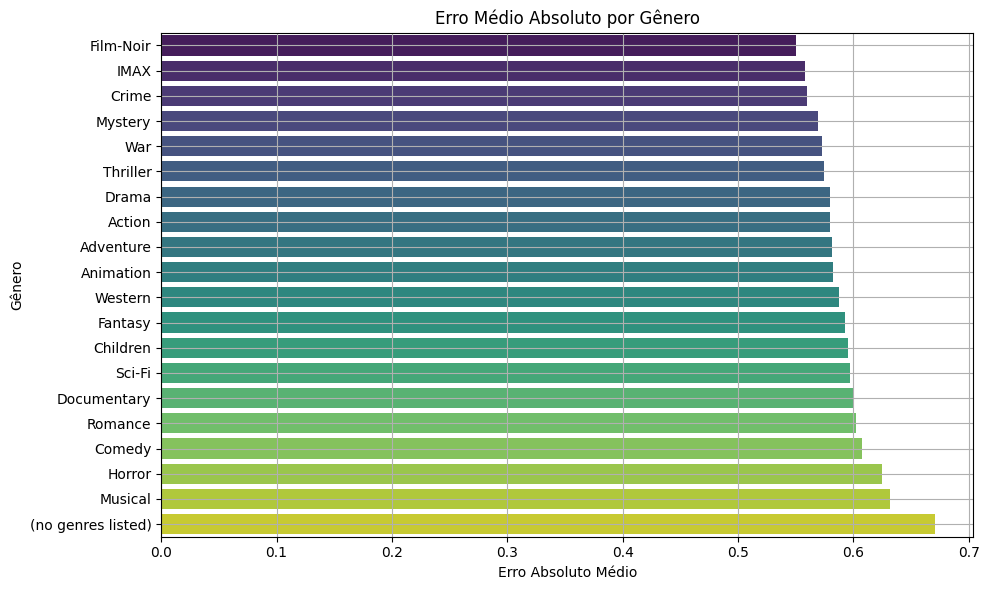

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Erro médio por gênero
df_resultado_10["genres"] = df_resultado_10["genres"].str.split("|")
df_exploded = df_resultado_10.explode("genres")

erro_medio_por_genero = df_exploded.groupby("genres")["erro_absoluto"].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=erro_medio_por_genero.values, y=erro_medio_por_genero.index, palette="viridis")
plt.title("Erro Médio Absoluto por Gênero")
plt.xlabel("Erro Absoluto Médio")
plt.ylabel("Gênero")
plt.grid(True)
plt.tight_layout()
plt.show()


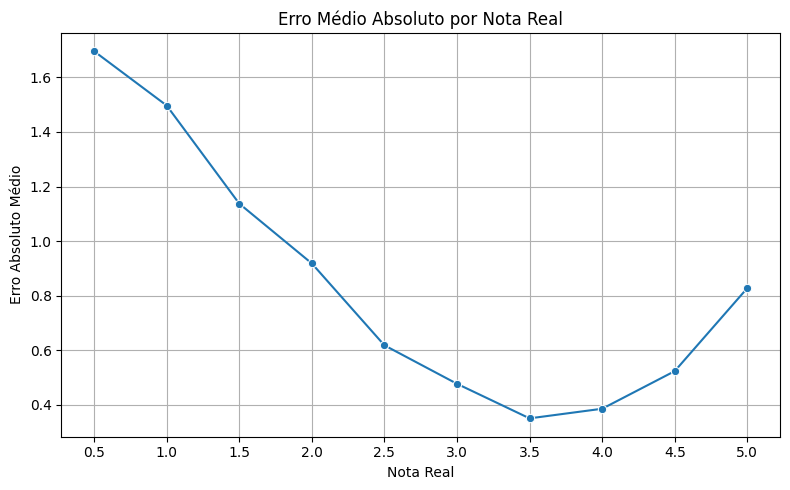

In [15]:

# 2. Erro médio por nota real
erro_medio_por_nota = df_resultado_10.groupby("rating_real")["erro_absoluto"].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=erro_medio_por_nota.index, y=erro_medio_por_nota.values, marker="o")
plt.title("Erro Médio Absoluto por Nota Real")
plt.xlabel("Nota Real")
plt.ylabel("Erro Absoluto Médio")
plt.grid(True)
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.tight_layout()
plt.show()


In [13]:

# 3. Matriz de correlação
df_corr = df_resultado_10[["rating_real", "rating_previsto", "erro_absoluto"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(df_corr, annot=True, cmap="blue", fmt=".2f")
plt.title("Matriz de Correlação: Notas e Erro")
plt.tight_layout()
plt.show()


NameError: name 'df_resultado_10' is not defined

In [35]:
df_lancamentos = pd.read_excel("filmes_lancamentos_api_US_2.xlsx")
df_lancamentos.head(7)

,Unnamed: 0,titulo,data,generos,ano,mes,generos_str
0,0,Demon Slayer: Kimetsu no Yaiba Infinity Castle,2025-09-12,"['Animation', 'Action', 'Fantasy', 'Thriller']",2025,9,"Animation, Action, Fantasy, Thriller"
1,1,The Conjuring: Last Rites,2025-09-05,['Horror'],2025,9,Horror
2,2,Nobody 2,2025-08-15,"['Action', 'Thriller']",2025,8,"Action, Thriller"
3,3,Red Sonja,2025-08-13,"['Adventure', 'Action', 'Fantasy']",2025,8,"Adventure, Action, Fantasy"
4,4,KPop Demon Hunters,2025-06-20,"['Animation', 'Comedy', 'Fantasy', 'Music']",2025,6,"Animation, Comedy, Fantasy, Music"
5,5,Ne Zha 2,2025-02-12,"['Animation', 'Fantasy', 'Adventure', 'Action']",2025,2,"Animation, Fantasy, Adventure, Action"
6,6,The Long Walk,2025-09-12,"['Horror', 'Science Fiction', 'Thriller']",2025,9,"Horror, Science Fiction, Thriller"


In [36]:
def calcular_rating_medio_por_genero(df_resultado, user_id):
    """
    Retorna a média do rating previsto por gênero para um usuário específico.
    """
    df_user = df_resultado[df_resultado["userId"] == user_id]
    display(df_user)
    df_exploded = df_user.copy()
    df_exploded = df_exploded.explode("genres")
    display(df_exploded.head(7))

    df_rating_medio = df_exploded.groupby("genres")["rating_previsto"].mean().reset_index()
    df_rating_medio.columns = ["genero", "rating_previsto_medio"]

    display(df_rating_medio.head())
    return df_rating_medio

def estimar_rating_lancamento_por_genero(lancamento_generos, rating_medio_por_genero):
    """
    Estima o rating de um lançamento pela média dos ratings previstos dos seus gêneros.
    """
    generos = [g.strip() for g in lancamento_generos.split(',')]
    notas = []

    for genero in generos:
        nota = rating_medio_por_genero[rating_medio_por_genero["genero"] == genero]["rating_previsto_medio"]
        if not nota.empty:
            notas.append(nota.values[0])

    return sum(notas) / len(notas) if notas else 0

def recomendar_lancamentos_por_rating_previsto(df_resultado, df_lancamentos, user_id, top_n=5):
    rating_medio_por_genero = calcular_rating_medio_por_genero(df_resultado, user_id)
    
    df_copy = df_lancamentos.copy()
    df_copy["rating_est"] = df_copy["generos_str"].apply(
        lambda x: estimar_rating_lancamento_por_genero(x, rating_medio_por_genero)
    )
    
    return df_copy[df_copy["rating_est"] > 0].sort_values("rating_est", ascending=False).head(top_n)


top_lancamentos = recomendar_lancamentos_por_rating_previsto(
    df_resultado=df_resultado_10,
    df_lancamentos=pd.read_excel("filmes_lancamentos_api_en.xlsx"),
    user_id=1,
    top_n=10
)

display(top_lancamentos[["titulo", "generos_str", "rating_est"]])




,userId,movieId,rating_real,rating_previsto,erro_absoluto,title,genres
1284865,1,6539,3.5,3.598040,0.098040,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
1284866,1,7939,2.5,3.990221,1.490221,Through a Glass Darkly (Såsom i en spegel) (1961),Drama
1284867,1,2011,2.5,3.074822,0.574822,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1284868,1,4973,4.5,4.195710,0.304290,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance


,userId,movieId,rating_real,rating_previsto,erro_absoluto,title,genres
1284865,1,6539,3.5,3.598040,0.098040,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
1284866,1,7939,2.5,3.990221,1.490221,Through a Glass Darkly (Såsom i en spegel) (1961),Drama
1284867,1,2011,2.5,3.074822,0.574822,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1284868,1,4973,4.5,4.195710,0.304290,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance


,genero,rating_previsto_medio
0,Action|Adventure|Comedy|Fantasy,3.598040
1,Adventure|Comedy|Sci-Fi,3.074822
2,Comedy|Romance,4.195710
3,Drama,3.990221


,titulo,generos_str,rating_est
5,Karate Kid: Legends,"Action, Adventure, Drama",3.990221
12,Memoir of a Snail,"Animation, Drama, Comedy",3.990221
70,The Woman of Weight,"Documentary, Drama, Family",3.990221
71,Old Nepo,Drama,3.990221
73,MAI,"Drama, Fantasy",3.990221
74,Fiz as malas pra te ver partir,Drama,3.990221
75,Not Tomorrow Yet,Drama,3.990221
78,The Interview,Drama,3.990221
85,Ruído,"Drama, Mystery",3.990221
86,Rosetta,"Animation, Drama",3.990221


In [ ]:
import numpy as np

def calcular_rating_ponderado_por_genero(df_resultado, user_id, gamma=1.0):
    """
    Calcula a média e a contagem de interações por gênero para um usuário.
    Agora aplica um peso dinâmico baseado na frequência (count).
    gamma controla a intensidade: 
        - gamma > 1 dá mais peso a gêneros frequentes
        - gamma < 1 suaviza
    """
    df_user = df_resultado[df_resultado["userId"] == user_id].copy()
    df_user["genres"] = df_user["genres"].apply(lambda x: x if isinstance(x, list) else str(x).split("|"))
    df_exploded = df_user.explode("genres")

    df_grouped = df_exploded.groupby("genres").agg(
        rating_previsto_medio=("rating_previsto", "mean"),
        count=("rating_previsto", "count")
    ).reset_index()

    df_grouped.columns = ["genero", "rating_previsto_medio", "count"]

    df_grouped["peso"] = np.log1p(df_grouped["count"]) ** gamma

    display(df_grouped)
    return df_grouped


def estimar_rating_lancamento_ponderado(generos_str, df_rating_por_genero):
    """
    Estima o rating para um lançamento com base na média ponderada de gêneros,
    usando os pesos dinâmicos.
    """
    generos = [g.strip() for g in generos_str.split(',')]
    notas_pesadas = []
    pesos = []

    for genero in generos:
        linha = df_rating_por_genero[df_rating_por_genero["genero"] == genero]
        if not linha.empty:
            nota = linha["rating_previsto_medio"].values[0]
            peso = linha["peso"].values[0]   # peso dinamico
            notas_pesadas.append(nota * peso)
            pesos.append(peso)

    return sum(notas_pesadas) / sum(pesos) if pesos else 0


def recomendar_lancamentos_ponderado(df_resultado, df_lancamentos, user_id, gamma=1.0, top_n=5):
    df_rating_por_genero = calcular_rating_ponderado_por_genero(df_resultado, user_id, gamma=gamma)
    df_copy = df_lancamentos.copy()

    df_copy["rating_est_ponderado"] = df_copy["generos_str"].apply(
        lambda x: estimar_rating_lancamento_ponderado(x, df_rating_por_genero)
    )

    return df_copy[df_copy["rating_est_ponderado"] > 0].sort_values(
        "rating_est_ponderado", ascending=False
    ).head(top_n)


In [ ]:
# Comparar ponderado normal vs dinâmico
recomendacoes_normais = recomendar_lancamentos_ponderado(df_resultado_10, df_lancamentos, user_id=3, gamma=1.0, top_n=10)
recomendacoes_reforcadas = recomendar_lancamentos_ponderado(df_resultado_10, df_lancamentos, user_id=3, gamma=1.5, top_n=10)

print("Ponderado Normal")
display(recomendacoes_normais[["titulo", "generos_str", "rating_est_ponderado"]])

print("Ponderado Dinâmico (gamma=1.5)")
display(recomendacoes_reforcadas[["titulo", "generos_str", "rating_est_ponderado"]])


,genero,rating_previsto_medio,count,peso
0,Action,3.681621,36,3.610918
1,Adventure,3.771147,19,2.995732
2,Animation,3.741614,10,2.397895
3,Children,3.651722,12,2.564949
4,Comedy,3.653765,21,3.091042
5,Crime,3.807723,12,2.564949
6,Documentary,3.887850,1,0.693147
7,Drama,3.927152,25,3.258097
8,Fantasy,3.581099,9,2.302585
9,Horror,3.809634,5,1.791759


,genero,rating_previsto_medio,count,peso
0,Action,3.681621,36,6.861616
1,Adventure,3.771147,19,5.185068
2,Animation,3.741614,10,3.713174
3,Children,3.651722,12,4.107884
4,Comedy,3.653765,21,5.434473
5,Crime,3.807723,12,4.107884
6,Documentary,3.887850,1,0.577083
7,Drama,3.927152,25,5.880929
8,Fantasy,3.581099,9,3.494005
9,Horror,3.809634,5,2.398389


=== Ponderado Normal ===


,titulo,generos_str,rating_est_ponderado
19,731,"Drama, War",4.004445
47,Dead to Rights,"Drama, War, History",4.004445
55,Dongji Rescue,"Drama, History, War",4.004445
102,Brownsville Bred,Drama,3.927152
106,Sunfish (& Other Stories on Green Lake),Drama,3.927152
23,Hamilton,"History, Drama",3.927152
233,Coconut Girl,Drama,3.927152
136,Maa Jaye,Drama,3.927152
167,Leaving Mom,"Family, Drama",3.927152
72,Another End,"Science Fiction, Drama",3.927152


=== Ponderado Dinâmico (gamma=1.5) ===


,titulo,generos_str,rating_est_ponderado
47,Dead to Rights,"Drama, War, History",3.977342
55,Dongji Rescue,"Drama, History, War",3.977342
19,731,"Drama, War",3.977342
88,Dreams (Sex Love),Drama,3.927152
102,Brownsville Bred,Drama,3.927152
100,A Little Prayer,Drama,3.927152
99,Bang Bang,Drama,3.927152
94,Chaperone,Drama,3.927152
93,My Sunshine,Drama,3.927152
105,I Never Said Goodbye,Drama,3.927152


## Modelo Supervisionado

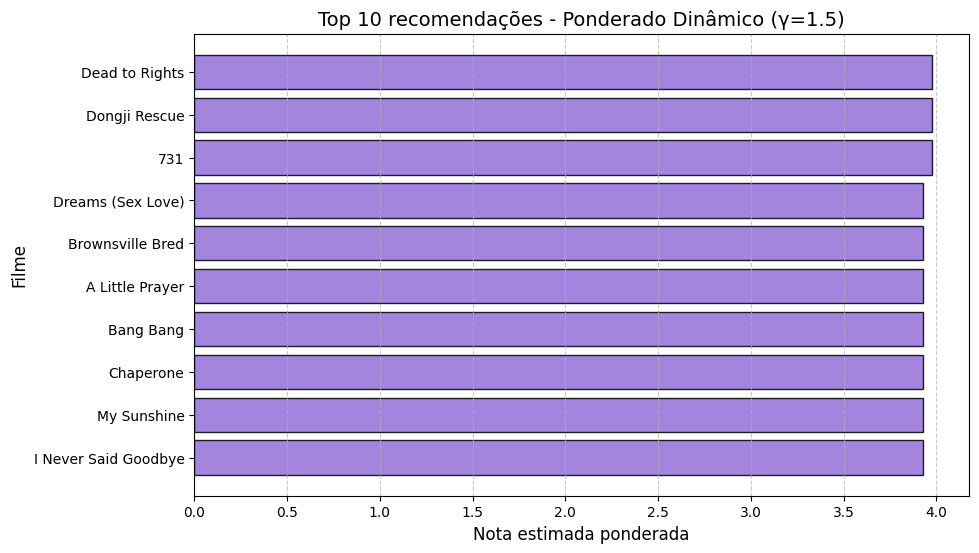

In [39]:
import matplotlib.pyplot as plt

# Seleciona os 10 primeiros resultados já ordenados
top10_dinamico = recomendacoes_reforcadas[["titulo", "rating_est_ponderado"]].head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_dinamico["titulo"], top10_dinamico["rating_est_ponderado"], 
         color="mediumpurple", edgecolor="black", alpha=0.85)

plt.title("Top 10 recomendações - Ponderado Dinâmico (γ=1.5)", fontsize=14)
plt.xlabel("Nota estimada ponderada", fontsize=12)
plt.ylabel("Filme", fontsize=12)
plt.gca().invert_yaxis()  # deixa o filme com maior nota no topo
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

def preparar_dataset_treino(df_resultado):
    df = df_resultado.copy()
    df["genres"] = df["genres"].apply(lambda x: x if isinstance(x, list) else str(x).split("|"))

    mlb = MultiLabelBinarizer()
    genero_onehot = pd.DataFrame(mlb.fit_transform(df["genres"]), columns=mlb.classes_)
    df = pd.concat([df.reset_index(drop=True), genero_onehot], axis=1)

    media_usuario = df.groupby("userId")["rating_previsto"].mean().to_dict()
    df["media_usuario"] = df["userId"].map(media_usuario)
    df["num_generos"] = df["genres"].apply(len)
    df["target"] = df["rating_real"]

    features = genero_onehot.columns.tolist() + ["media_usuario", "num_generos"]
    X = df[features]
    y = df["target"]

    return X, y, mlb, features


def avaliar_modelos_por_profundidade(X, y, depths=[5, 10, 20, None], n_estimators=100):
    print("Avaliação por validação cruzada (R² médio):\n")
    resultados = []
    for d in depths:
        modelo = RandomForestRegressor(n_estimators=n_estimators, max_depth=d, random_state=42, n_jobs=-1)
        scores = cross_val_score(modelo, X, y, cv=3, scoring='r2')
        media = np.mean(scores)
        print(f"max_depth = {str(d):>4} → R² médio: {media:.4f}")
        resultados.append((str(d), media))
    return resultados

import matplotlib.pyplot as plt

def plotar_resultados_r2(resultados):
    labels, valores = zip(*resultados)
    plt.figure(figsize=(8, 5))
    plt.plot(labels, valores, marker='o')
    plt.title("Comparação de R² por max_depth")
    plt.xlabel("max_depth")
    plt.ylabel("R² médio (validação cruzada)")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()



Avaliação por validação cruzada (R² médio):

max_depth =    5 → R² médio: 0.2093
max_depth =   10 → R² médio: 0.2253
max_depth =   20 → R² médio: 0.2200
max_depth = None → R² médio: -0.0120


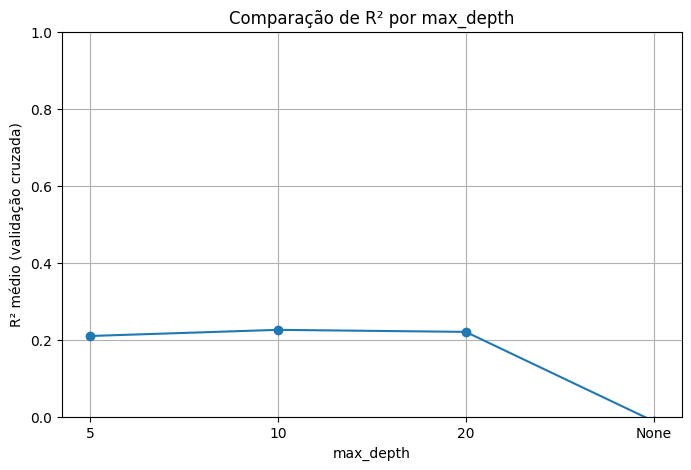

In [ ]:
#identificar r²
X, y, mlb, features = preparar_dataset_treino(df_resultado_10)
resultados_r2 = avaliar_modelos_por_profundidade(X, y)
plotar_resultados_r2(resultados_r2)


In [ ]:
#usar modelo melhor
modelo = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
modelo.fit(X, y)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [51]:
import pandas as pd
df_lancamentos = pd.read_excel("filmes_lancamentos_api_US_2.xlsx")
df_lancamentos.head(7)

,Unnamed: 0,titulo,data,generos,ano,mes,generos_str
0,0,Demon Slayer: Kimetsu no Yaiba Infinity Castle,2025-09-12,"['Animation', 'Action', 'Fantasy', 'Thriller']",2025,9,"Animation, Action, Fantasy, Thriller"
1,1,The Conjuring: Last Rites,2025-09-05,['Horror'],2025,9,Horror
2,2,Nobody 2,2025-08-15,"['Action', 'Thriller']",2025,8,"Action, Thriller"
3,3,Red Sonja,2025-08-13,"['Adventure', 'Action', 'Fantasy']",2025,8,"Adventure, Action, Fantasy"
4,4,KPop Demon Hunters,2025-06-20,"['Animation', 'Comedy', 'Fantasy', 'Music']",2025,6,"Animation, Comedy, Fantasy, Music"
5,5,Ne Zha 2,2025-02-12,"['Animation', 'Fantasy', 'Adventure', 'Action']",2025,2,"Animation, Fantasy, Adventure, Action"
6,6,The Long Walk,2025-09-12,"['Horror', 'Science Fiction', 'Thriller']",2025,9,"Horror, Science Fiction, Thriller"


In [52]:
def preparar_lancamentos_para_predicao(df_lancamentos, user_id, df_resultado, mlb, features):
    """
    Prepara os lançamentos para predição, padronizando os gêneros e gerando as mesmas features do treino.
    """
    # Média do usuário
    df_user = df_resultado[df_resultado["userId"] == user_id]
    media = df_user["rating_previsto"].mean()

    df = df_lancamentos.copy()

    # Mapeamento de gêneros para padronização com MovieLens
    mapa_generos = {
        "Music": "Musical",
        "Science Fiction": "Sci-Fi",
        "Family": "Children",
    }

    # Gêneros em lista padronizados
    df["generos_list"] = df["generos_str"].str.split(",").apply(
        lambda lst: [mapa_generos.get(g.strip(), g.strip()) for g in lst]
    )

    # Filtrar apenas os gêneros conhecidos pelo modelo
    generos_validos = set(mlb.classes_)
    df["generos_list"] = df["generos_list"].apply(
        lambda lst: [g for g in lst if g in generos_validos]
    )

    # Aplicar o one-hot
    genero_onehot = pd.DataFrame(mlb.transform(df["generos_list"]), columns=mlb.classes_)
    df = pd.concat([df.reset_index(drop=True), genero_onehot], axis=1)

    # Features adicionais
    df["media_usuario"] = media
    df["num_generos"] = df["generos_list"].apply(len)

    # Montar o X para predição
    X_pred = df[features]
    return df, X_pred


def prever_rating_lancamentos(modelo, df_lancamentos, X_pred):
    """
    Recebe o modelo treinado, os lançamentos originais e os dados preparados (X_pred),
    e retorna o DataFrame com uma nova coluna: rating_ml (nota prevista pelo modelo).
    """
    df_lancamentos = df_lancamentos.copy()
    df_lancamentos["rating_ml"] = modelo.predict(X_pred)
    return df_lancamentos.sort_values("rating_ml", ascending=False)



In [53]:
df_lancamentos_user, X_pred = preparar_lancamentos_para_predicao(
    df_lancamentos, user_id=1, df_resultado=df_resultado_10, mlb=mlb, features=features
)


In [54]:

recomendacoes_ml = prever_rating_lancamentos(modelo, df_lancamentos_user, X_pred)


In [55]:
display(recomendacoes_ml)

,Unnamed: 0,titulo,data,generos,ano,mes,generos_str,generos_list,(no genres listed),Action,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,media_usuario,num_generos,rating_ml
224,256,OG_Kush: Betting Shop,2025-08-21,"['Drama', 'Crime']",2025,8,"Drama, Crime","[Drama, Crime]",0,0,...,0,0,0,0,0,0,0,3.714698,2,4.079400
34,41,Nishaanchi,2025-09-19,"['Crime', 'Drama']",2025,9,"Crime, Drama","[Crime, Drama]",0,0,...,0,0,0,0,0,0,0,3.714698,2,4.079400
15,16,American Sweatshop,2025-09-19,"['Thriller', 'Mystery']",2025,9,"Thriller, Mystery","[Thriller, Mystery]",0,0,...,0,1,0,0,1,0,0,3.714698,2,4.013624
55,63,Dongji Rescue,2025-08-22,"['Drama', 'History', 'War']",2025,8,"Drama, History, War","[Drama, War]",0,0,...,0,0,0,0,0,1,0,3.714698,2,3.964920
19,20,731,2025-09-19,"['Drama', 'War']",2025,9,"Drama, War","[Drama, War]",0,0,...,0,0,0,0,0,1,0,3.714698,2,3.964920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,78,Rabbit Trap,2025-09-12,"['Horror', 'Mystery', 'Thriller']",2025,9,"Horror, Mystery, Thriller","[Horror, Mystery, Thriller]",0,0,...,0,1,0,0,1,0,0,3.714698,3,3.386344
91,101,The Man in My Basement,2025-09-12,"['Horror', 'Mystery', 'Thriller']",2025,9,"Horror, Mystery, Thriller","[Horror, Mystery, Thriller]",0,0,...,0,1,0,0,1,0,0,3.714698,3,3.386344
218,247,48 NOIDED MOVIES,2025-08-13,"['Animation', 'Mystery', 'Documentary', 'Horro...",2025,8,"Animation, Mystery, Documentary, Horror, Scien...","[Animation, Mystery, Documentary, Horror, Sci-...",0,1,...,0,1,0,1,1,1,0,3.714698,10,3.302589
112,123,American Summer,2025-08-29,"['Comedy', 'Family']",2025,8,"Comedy, Family","[Comedy, Children]",0,0,...,0,0,0,0,0,0,0,3.714698,2,3.230599


In [ ]:
user_id = 3


# Método supervisionado
df_lancamentos_user, X_pred = preparar_lancamentos_para_predicao(
    df_lancamentos, user_id, df_resultado_10, mlb, features
)
df_ml = prever_rating_lancamentos(modelo, df_lancamentos_user, X_pred)

# Método ponderado
df_ponderado = recomendar_lancamentos_ponderado(
    df_resultado_10, df_lancamentos, user_id, top_n=1000  # usa top_n alto para manter todos
)


df_hibrido = df_ml.merge(
    df_ponderado[["titulo", "rating_est_ponderado"]],
    on="titulo",
    how="left"
)


df_hibrido["rating_est_ponderado"] = df_hibrido["rating_est_ponderado"].fillna(0)


def calcular_rating_hibrido(row, alpha=0.7, beta=0.3, alpha_cold=0.4, beta_cold=0.6):
    if row["rating_est_ponderado"] == 0:  # item cold-start
        return row["rating_ml"] * beta_cold + row["rating_est_ponderado"] * alpha_cold
    else:
        return row["rating_ml"] * alpha + row["rating_est_ponderado"] * beta

df_hibrido["rating_hibrido"] = df_hibrido.apply(calcular_rating_hibrido, axis=1)


recomendacoes_finais = df_hibrido.sort_values("rating_hibrido", ascending=False)
display(recomendacoes_finais[["data","titulo", "rating_ml", "rating_est_ponderado", "rating_hibrido", 'generos_str']].head(80))
df = recomendacoes_finais[["data","titulo", "rating_ml", "rating_est_ponderado", "rating_hibrido", 'generos_str']].head(120)
# df.to_excel("teste_final.xlsx")


debug_row = df_hibrido[df_hibrido["titulo"].str.contains("Demon Slayer", case=False, na=False)]
display(debug_row[["data","titulo", "rating_ml", "rating_est_ponderado", "rating_hibrido", 'generos_str']])

,genero,rating_previsto_medio,count,peso
0,Action,3.681621,36,3.610918
1,Adventure,3.771147,19,2.995732
2,Animation,3.741614,10,2.397895
3,Children,3.651722,12,2.564949
4,Comedy,3.653765,21,3.091042
5,Crime,3.807723,12,2.564949
6,Documentary,3.887850,1,0.693147
7,Drama,3.927152,25,3.258097
8,Fantasy,3.581099,9,2.302585
9,Horror,3.809634,5,1.791759


,data,titulo,rating_ml,rating_est_ponderado,rating_hibrido,generos_str
3,2025-08-22,Dongji Rescue,4.081523,4.004445,4.058399,"Drama, History, War"
4,2025-09-19,731,4.081523,4.004445,4.058399,"Drama, War"
5,2025-08-15,Dead to Rights,4.081523,4.004445,4.058399,"Drama, War, History"
0,2025-09-19,American Sweatshop,4.100863,3.851023,4.025911,"Thriller, Mystery"
2,2025-09-19,Nishaanchi,4.087201,3.874545,4.023404,"Crime, Drama"
...,...,...,...,...,...,...
62,2025-09-12,Bang Bang,3.878322,3.927152,3.892971,Drama
63,2025-08-29,A Little Prayer,3.878322,3.927152,3.892971,Drama
64,2025-09-17,Bauryna Salu,3.878322,3.927152,3.892971,Drama
85,2025-08-15,East of Wall,3.867943,3.927152,3.885706,"Drama, Western"


,data,titulo,rating_ml,rating_est_ponderado,rating_hibrido,generos_str
116,2025-09-12,Demon Slayer: Kimetsu no Yaiba Infinity Castle,3.802824,3.70492,3.773453,"Animation, Action, Fantasy, Thriller"
